# Regresión (multivariada)

La **_regresión_** es uno de los modelos genéricos básicos del análisis estadístico y por extensión, de la inteligencia computacional. El propósito de la _regresión_ es **predecir** valores.

En el ámbito de la inteligencia computacional la regresión se reduce a un caso de _clasificación_ donde las clases son todos los posibles valores, i.e. las clases son todo el conjunto de los reales.

Por esta razón, existen diversos modelos que atacan diversos tipos de datasets que se pueden analizar. Por ejemplo, cuando se tienen dos variables _linealmente_ correlacionadas el modelo más fácil (y el mejor) sería el modelo estándar lineal que técnicamente minimiza la desviación estándar entre los errores. Pero cuando las variables no son solamente 2, y adicionalmente no están relacionadas linealmente, ¿cuál es el mejor modelo a utilizar?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import *
from scipy.stats import randint as sp_randint
from statsmodels.nonparametric.smoothers_lowess import lowess

# Utilizar el tema default de seaborn
sns.set()

## Dataset de _diabetes_

Este conjunto de datos proviene de un [estudio](http://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf) de análisis de regresión donde se propone un nuevo (para el año cuando se publicó) método de regresión que intenta mejorar el modelo estándar de regresión por _mínimos cuadrados_. Este método es Lasso-LARS y está incluido en esta libreta.

En general, este conjunto de datos contiene 10 variables, las cuales son:

1. Edad
2. Género
3. Índice de masa corporal
4. Presión arterial promedio
5. $S_1$
6. $S_2$
7. $S_3$
8. $S_4$
9. $S_5$
10. $S_6$

donde las variables $S$ se refieren a mediciones hechas sobre el suero de la sangre. La variable objetivo es el avance de la diabetes en ese paciente en específico después de un año de haber realizado estas mediciones. 

El objetivo de este conjunto de datos es encontrar cuál de todas las variables son las que más contribuyen a la predicción efectiva de la variable objetivo. En particular, en esta libreta se realizará un estudio riguroso de diversos métodos de regresión lineal y se compararán los resultados obtenidos.

## 1. Extracción y exploración básica de datos

In [2]:
# Importar los datos
diab_data = datasets.load_diabetes()

In [3]:
# Observar los datos
print(diab_data['data'])
# Y su tamaño
print(diab_data['data'].shape)

[[ 0.03807591  0.05068012  0.06169621 ... -0.00259226  0.01990842
  -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 ... -0.03949338 -0.06832974
  -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 ... -0.00259226  0.00286377
  -0.02593034]
 ...
 [ 0.04170844  0.05068012 -0.01590626 ... -0.01107952 -0.04687948
   0.01549073]
 [-0.04547248 -0.04464164  0.03906215 ...  0.02655962  0.04452837
  -0.02593034]
 [-0.04547248 -0.04464164 -0.0730303  ... -0.03949338 -0.00421986
   0.00306441]]
(442, 10)


In [4]:
# Verificar si faltan valores
np.any(np.isnan(diab_data['data']))

False

In [5]:
# Observar cuáles son las categorías
diab_data['feature_names']

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [6]:
# Crear una matriz de correlación para explorar los datos y su relación
correlations = np.corrcoef(diab_data['data'])
correlations

array([[ 1.        , -0.41008995,  0.88093929, ...,  0.49704288,
        -0.02372811, -0.81268687],
       [-0.41008995,  1.        , -0.14889115, ..., -0.13090505,
        -0.31169288,  0.66521773],
       [ 0.88093929, -0.14889115,  1.        , ...,  0.62421729,
        -0.30644307, -0.63365587],
       ...,
       [ 0.49704288, -0.13090505,  0.62421729, ...,  1.        ,
        -0.77182109, -0.50189123],
       [-0.02372811, -0.31169288, -0.30644307, ..., -0.77182109,
         1.        , -0.14226611],
       [-0.81268687,  0.66521773, -0.63365587, ..., -0.50189123,
        -0.14226611,  1.        ]])

<Figure size 864x576 with 0 Axes>

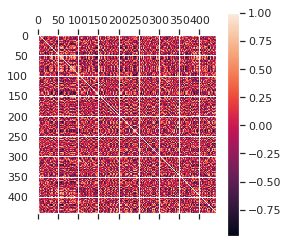

In [7]:
# Mostrar una matriz de correlación entre los datos
plt.figure(figsize=(12,8))
plt.matshow(correlations)
plt.colorbar()
plt.show()

Como un acercamiento básico al análisis de estos datos, realizar una matriz de correlación y graficarla puede ser de ayuda. En este caso se puede observar que muchos de los datos entre sí están altamente correlacionados, definitivamente no se puede extraer un solo par de características para realizar una regresión lineal.

También es útil notar que la matriz de correlación está muy poblada y los colores empiezan a _perderse_ pero es una ayuda visual para la exploración inicial de los datos.

In [8]:
# Separar el conjunto de datos en entrenamiento y prueba, 80/20
x_train, x_test, y_train, y_test = model_selection.train_test_split(diab_data['data'], diab_data['target'],
                                                                   test_size=0.2)

## 2. Árboles de decisiones con un _Extremely Randomized Forest_

Los _árboles de decisiones_ son parte de algoritmos que ayudan a encontrar qué características dentro de los datos son los más importantes conocidos como _métodos de **ensambles**_. Esto se logra a través de crear probabilidades según la relación directa entre las características de los datos. Con este tipo de algoritmos se pueden ajustar modelos de regresión para variables que están muy correlacionadas entre sí.

Una de las _ventajas_ de este tipo de algoritmos es que permite realizar regresiones para datos que están correlacionados entre sí, pero su mayor _desventaja_ es que cuando son datos con una dimensionalidad muy alta entonces estos algoritmos tienden a **sobreajustarse.**

In [9]:
# Crear el random forest
forest = ensemble.ExtraTreesRegressor(n_estimators=500)
# Crear un diccionario de posibles valores para realizar la validación cruzada de los 
# hiperparámetros
param_dist = {'max_depth': sp_randint(1, 20),
              'max_features': ['auto', 'sqrt', 'log2'],
             'min_samples_split': sp_randint(2, 10),
              'min_samples_leaf': sp_randint(1, 50)
             }
# Dado que son muchos valores se realizará una validación cruzada aleatoria con 40 muestras
n_iter_search = 40
# ALERTA: Esto puede ralentizar la computadora pues utilizará todos los núcleos disponibles de la computadora
random_search = model_selection.RandomizedSearchCV(forest, param_distributions=param_dist,
                                   scoring='neg_mean_squared_error',n_iter=n_iter_search,
                                    cv=10, iid=False, n_jobs=-1)
# Ajustar el conjunto de datos
random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=40, n_jobs=-1,
          param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27754dd2e8>, 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27754ddb00>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f2775488160>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error'

In [10]:
# Usar los mejores parámetros y aumentar el número de árboles
best_forest = ensemble.ExtraTreesRegressor(n_estimators=700, **random_search.best_params_)
best_forest.fit(x_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=9,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=5, min_samples_split=3,
          min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=None,
          oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
# Revisar si hay sobreajuste en el modelo ERF
print(best_forest.score(x_train, y_train))
print(best_forest.score(x_test, y_test))

0.7268168119657608
0.4605890604169601


Efectivamente hay _sobreajuste_ como se esperaba dado que el valor de $R^2$ de la predicción de los datos de entrenamiento es superior a los datos de prueba. Sin embargo, no hace falta realizar más ajuste de hiperparámetros, aunque sin duda es un excelente ejercicio, pues no se podrá sacar mucho más provecho de este algoritmo.

Lo que sí se puede obtener es un resumen más detallado de cuáles de estas características son las más importantes para realizar la estimación, que es lo que se hará a continuación.

### 2.1. Ver una gráfica de las características más importantes

Se mencionaba que este tipo de métodos pueden extraer las características más importantes y esto lo realizan a través de un valor conocido como **impureza de Gini**, que para el caso de _regresión_ se escribe como $$I_G(p) = 1 - \sum_{i = 1}^{\infty} p_i$$ donde $p_i$ es la probabilidad de que un valor $i$ sea escogido.

De aquí que las características que tienen un valor más alto de _impuridad de Gini_ son las que se escogen como las que más impacto tienen sobre los datos. Esto se puede ver en una gráfica.

Ranking de características:
1. feature 8 (0.3222314152634356)
2. feature 2 (0.26510566308342154)
3. feature 3 (0.11309372532067569)
4. feature 7 (0.09078398952173151)
5. feature 9 (0.06625305506983646)
6. feature 6 (0.04574241524620161)
7. feature 1 (0.03739949799234323)
8. feature 0 (0.022876495209630927)
9. feature 5 (0.019312809567666525)
10. feature 4 (0.01720093372505662)


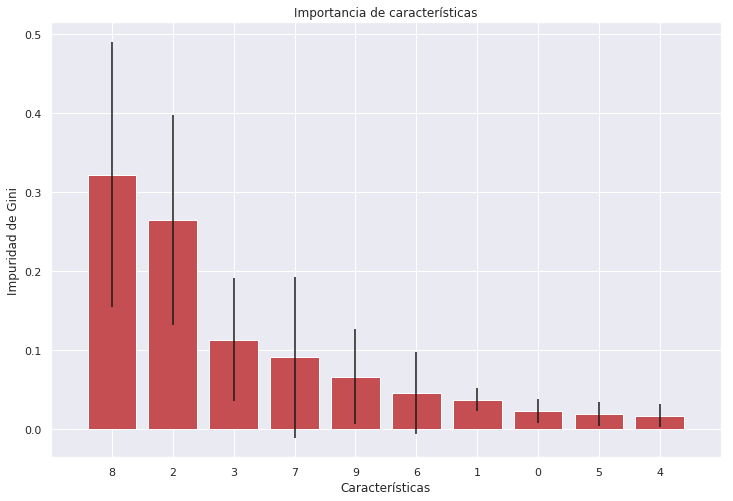

In [12]:
# Extraer las características más importantes
importances = best_forest.feature_importances_
# Calcular el error asociado
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_],
             axis=0)
# Ordenar según el valor más alto de impuridad de Gini
indices = np.argsort(importances)[::-1]

# Muestra una lista de los valores más importantes
print('Ranking de características:')
# Imprimir una lista con la impuridad de Gini de cada característica
for f in range(diab_data['data'].shape[1]):
    print('{0}. feature {1} ({2})'.format(f + 1, indices[f], importances[indices[f]]))

# Graficar la importancia de cada característica como una gráfica de barras,
# en orden descendiente de importancia
plt.figure(figsize=(12, 8))
plt.title('Importancia de características')
plt.bar(range(diab_data['data'].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(diab_data['data'].shape[1]), indices)
plt.xlim([-1, diab_data['data'].shape[1]])
plt.ylabel('Impuridad de Gini')
# El número de características están en formato de índices de Python
# i.e. 0 es la primera, 1 es la segunda y sucesivamente
plt.xlabel('Características')
plt.show()

Algo importante de esta figura es que en realidad dos de las 10 características son las importantes, pero se debe _notar_ lo siguiente: el error asociado es muy grande para cada medición.
Esto se puede deber a que el modelo se está _sobreajustando_ y no tenemos una verdadera medición estadística confiable, que sin duda es importante.

Esta gráfica también dicta que aunque son dos las más importantes, las demás también tienen una cierta contribución a la creación del modelo. Esto se retomará después en esta libreta.

## 2.2 Realizar y visualizar la predicción de _Extremely Randomized Forest_

In [13]:
# Realizar la predicción con este modelo
y_pred = best_forest.predict(x_test)

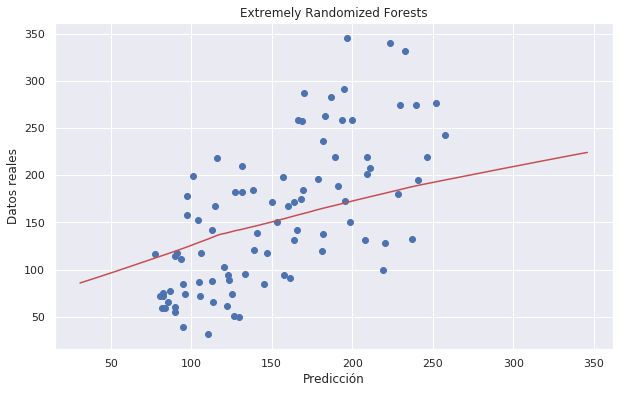

In [14]:
# Crear una visualización de este resultado
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test)
# Crear una línea de regresión pesada por los datos para ver el ajuste del modelo
line_plot = lowess(y_pred, y_test)
plt.plot(line_plot[:,0], line_plot[:,1], c='r')
plt.title('Extremely Randomized Forests')
plt.xlabel('Predicción')
plt.ylabel('Datos reales')
plt.show()

Aquí se espera ver que todos los datos de predicción y reales formen una línea recta pues esto indicaría que los datos han sido predichos correctamente. Sin embargo se puede ver que es muy difícil de tener este resultado con este modelo _sobreajustado_.

## 3. Regresión mediante SVM (Máquinas de soporte vectorial)

Uno de los métodos de inteligencia computacional más prominentes son las SVMs que permiten trabajar con datos de alta dimensionalidad. Aún mejor, este algoritmo se puede extender a regresión y es lo que se realiza aquí. Este método es un fuerte candidato para realizar una buena regresión, pero este método no creará un separación de características y una desventaja de este algoritmo es que el ajuste de hiperparámetros puede ser muy costoso computacionalmente.

In [15]:
# Crear diccionario de parámetros
params = {'C': [10, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
         'epsilon': [0.005, 0.01, 0.05, 0.1, 0.2, 0.3]}
# Crear la SVM para regresión con kernel radial
sv_reg = svm.SVR(kernel='rbf')
# Realizar validación cruzada para encontrar el mejor regresor
best_svr = model_selection.GridSearchCV(sv_reg, param_grid=params, 
                                        scoring='neg_mean_squared_error',iid=False, cv=10, n_jobs=-1)
# Entrenar el modelo
best_svr.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=False, n_jobs=-1,
       param_grid={'C': [10, 100.0, 1000.0, 5000.0, 10000.0, 50000.0, 100000.0, 500000.0], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], 'epsilon': [0.005, 0.01, 0.05, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [16]:
# Encontrar los valores predichos por el modelo
y_pred = best_svr.predict(x_test)

In [17]:
# Revisar si hay algún problema con el ajuste de SVM
print(best_svr.best_estimator_.score(x_train, y_train))
print(best_svr.best_estimator_.score(x_test, y_test))

0.5517322092661945
0.4995294178207218


Según este resultado anterior, existe un _sobreajuste_, aunque ligero, con el modelo. Sin embargo, este modelo ya está realizando un predicción aceptable y esto se puede verificar con la gráfica siguiente.

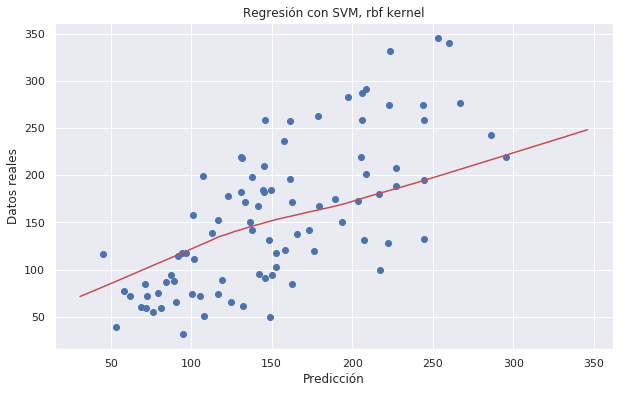

In [18]:
# Crear una visualización de este resultado
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test)
line_plot = lowess(y_pred, y_test)
plt.plot(line_plot[:,0], line_plot[:,1], c='r')
plt.title('Regresión con SVM, rbf kernel')
plt.xlabel('Predicción')
plt.ylabel('Datos reales')
plt.show()

Se esperaba tener un línea recta nuevamente, pero no existe esta relación lineal entre los datos predichos y los reales.

## 4. Gradient Boosting

El método de _ensamble_ de **Gradient Boosting** es la mejor substancial de los _Random Forests_. Básicamente este tipo de métodos lo que hacen es construir muchos árboles de decisión, pero los errores estadísticos (según una métrica estadística arbitraria) son minimizados paso por paso en cada una de las etapas de construcción de los árboles. La _ventaja_ de este método es que puede discernir entre diferentes características relacionadas entre sí, pero su mayor _desventaja_ es que es lento y es complicado de ajustar los hiperparámetros para evitar el _sobreajuste_.

In [19]:
# Parámetros para buscar
params = {'loss': ['ls', 'huber', 'lad'],
         'learning_rate': [0.1, 0.05, 0.02, 0.01],
         'max_depth': sp_randint(1,10),
          'min_samples_leaf': sp_randint(2,100),
          'max_features': sp_randint(2,11)
         }
# Crear el modelo
gr_est = ensemble.GradientBoostingRegressor(n_estimators=1000, subsample=0.5)
# Dado que son muchos valores a buscar, se realiza la búsqueda aleatoria
n_search = 40
gr_cv = model_selection.RandomizedSearchCV(gr_est, param_distributions=params, n_iter=n_search, cv=10, iid=False,
                                     scoring='neg_mean_squared_error', n_jobs=-1)
gr_cv.fit(x_train, y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=0.5, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
          fit_params=None, iid=False, n_iter=40, n_jobs=-1,
          param_distributions={'loss': ['ls', 'huber', 'lad'], 'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27754dd518>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27755acf60>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27755ac160>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=

In [20]:
# ¿Cuáles son los mejores parámetros encontrados?
gr_cv.best_params_

{'learning_rate': 0.01,
 'loss': 'huber',
 'max_depth': 6,
 'max_features': 3,
 'min_samples_leaf': 38}

## 4.1. Visualización de sobreajuste del modelo

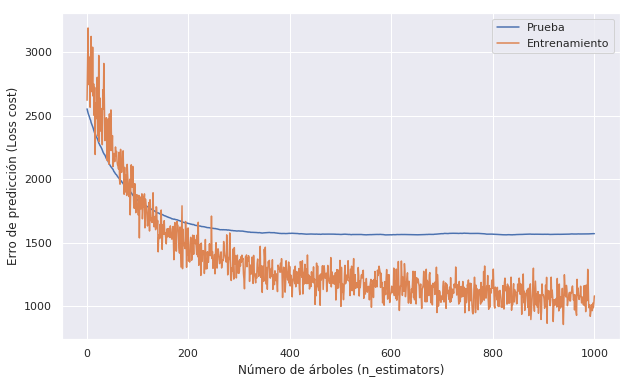

In [21]:
# Crear el modelo según los mejores parámetros encontrados
gr_est = ensemble.GradientBoostingRegressor(n_estimators=1000, subsample=0.5, **gr_cv.best_params_)
gr_est.fit(x_train, y_train)
# Se crea un arreglo vacío para guardar los valores de predicción
test_score = np.empty_like(gr_est.estimators_)
# Se itera sobre cada valor predicho y su valor de la métrica escogida, que en este caso es 'ls'
for i, pred in enumerate(gr_est.staged_predict(x_test)):
    test_score[i] = gr_est.loss_(y_test, pred)
# Se grafica la figura para prueba y entrenamiento
plt.figure(figsize=(10,6))
plt.plot(np.arange(1000)+1, test_score, label='Prueba')
plt.plot(np.arange(1000)+1, gr_est.train_score_, label='Entrenamiento')
plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('Erro de predicción (Loss cost)')
plt.legend(loc='best')

Hay sobrejuste del modelo, pero dado que es computacionalmente costoso ajustar este modelo se dejará así en esta libreta, aunque no es el modelo ideal y falta trabajo por realizar para que este modelo tenga un buen desempeño.

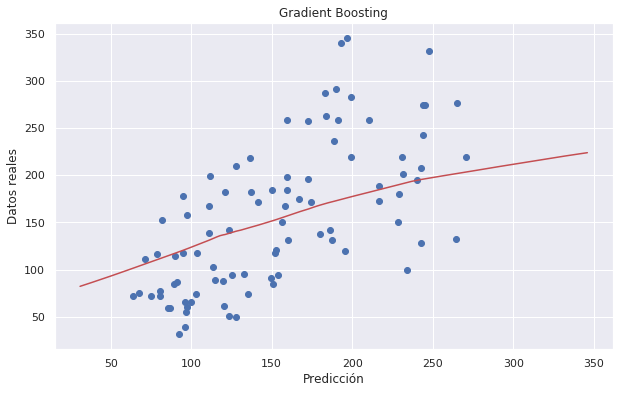

In [22]:
# Realizar la predicción con GBR
y_pred = gr_est.predict(x_test)

# Crear una visualización de este resultado
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test)
line_plot = lowess(y_pred, y_test)
plt.plot(line_plot[:,0], line_plot[:,1], c='r')
plt.title('Gradient Boosting')
plt.xlabel('Predicción')
plt.ylabel('Datos reales')
plt.show()

Nuevamente, no se encuentra una relación lineal entre los datos predichos y reales.

## 5. Lasso-LARS

El algoritmo de regresión **LASSO** (Least Absolute Shrinkage and Selection Operator) es un método de regresión muy robusto que se ajusta a datos multidimensionales altamente correlacionados entre sí.

Matemáticamente, este modelo es un problema de optimización que intenta minimizar una función de costo con un término adicional de penalización. Para mayor información, leer el [artículo original.](http://statweb.stanford.edu/~tibs/lasso/lasso.pdf) Normalmente este algoritmo se minimiza utilizando el método numérico de [_coordinate descent_](https://en.wikipedia.org/wiki/Coordinate_descent) dado que la función de costo contiene un valor absoluto que ocasionaría problemas para el método tradicional de _descenso de gradiente._

En particular, en esta libreta se utiliza un algoritmo diferente para realizar la minimización de Lasso, llamado **LARS** (Least Angle Regression), que fue creado con este conjunto de datos en mente, por lo que se predice que este sea el mejor método para este trabajo. El [artículo](https://web.stanford.edu/~hastie/Papers/LARS/LeastAngle_2002.pdf) original contiene el detalle matemático de cómo funciona este método.

In [23]:
# Utilizar la versión con validación cruzada integrada
reg = linear_model.LassoLarsCV(fit_intercept=True, max_iter=500, max_n_alphas=1000, cv=10, n_jobs=-1)
reg.fit(x_train, y_train)

LassoLarsCV(copy_X=True, cv=10, eps=2.220446049250313e-16, fit_intercept=True,
      max_iter=500, max_n_alphas=1000, n_jobs=-1, normalize=True,
      positive=False, precompute='auto', verbose=False)

In [24]:
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))

0.5169664123659903
0.5150677914915394


In [25]:
# Calcular el valor del error cuadrático medio de Lasso-LARS
lasso_mse = metrics.mean_squared_error(y_test, reg.predict(x_test))
lasso_mse

2864.0211330148118

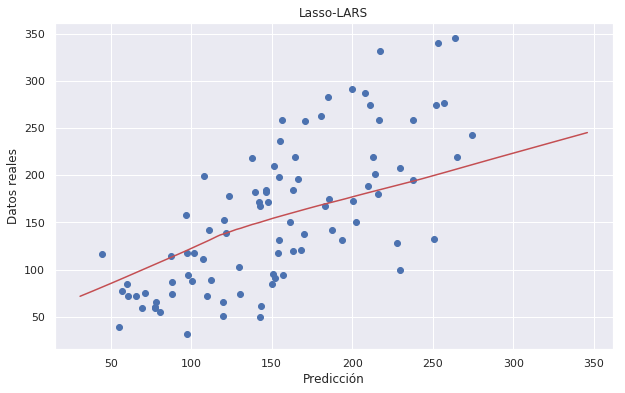

In [29]:
# Realizar la predicción con Lasso-LARS
y_pred = reg.predict(x_test)

# Crear una visualización de este resultado
plt.figure(figsize=(10,6))
plt.scatter(y_pred, y_test)
line_plot = lowess(y_pred, y_test)
plt.plot(line_plot[:,0], line_plot[:,1], c='r')
plt.title('Lasso-LARS')
plt.xlabel('Predicción')
plt.ylabel('Datos reales')
plt.show()

Creando el camino de regularización para Lasso ...
.

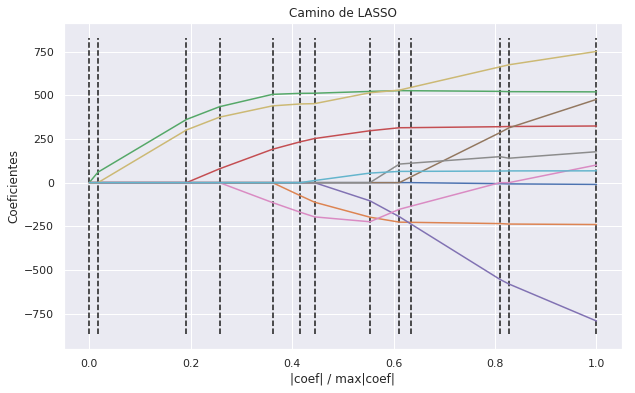

In [27]:
print("Creando el camino de regularización para Lasso ...")
__, active, coefs = linear_model.lars_path(diab_data['data'], diab_data['target'], method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,6))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coeficientes')
plt.title('Camino de LASSO')
plt.axis('tight')
plt.show()

Una de las grandes ventajas de la regresión Lasso es que puede discernir entre todas las características del conjunto de datos y detallar cuáles son más importantes. La gráfica anterior muestra este resultado.

En particular, cada línea dentro de la gráfica muestra el peso de cada característica que contiene el conjunto de dato y los pesos que tienen para atribuir al modelo de regresión que realizará la predicción.

Se pueden notar las siguientes cosas:

1. **Dos** características empiezan por tener todo el peso en las primeras iteraciones del modelo Lasso. Esto se había visto anteriormente con los _Extremely Randomized Forests_.
2. Cuando el modelo empieza a tomar en cuenta las demás características, empiezan a tener pesos semejantes, aunque menores.
3. Al final, el modelo utiliza __9__ de las **10** características totales para realiza la predicción pertinente.

Con esto se puede _concluir_ lo siguiente:

__9__ de las **10** características son necesarias para realizar una predicción adecuada del modelo, pero aún así, cualquier modelo realizará una predicción pobre por debajo del 60% de las veces. Por otro lado, solamente **2** características tienen el peso fundamental de la relación entre la predicción de las variables como tal.

In [28]:
print('ExtraRandomForest RMSE: {0}'.format(np.sqrt(np.abs(random_search.best_score_))))
print('SVR RMSE: {0}'.format(np.sqrt(np.abs(best_svr.best_score_))))
print('Gradient Boosting RMSE: {0}'.format(np.sqrt(np.abs(gr_cv.best_score_))))
print('Lasso-LARS RMSE: {0}'.format(np.sqrt(np.abs(lasso_mse))))

ExtraRandomForest RMSE: 55.689568429586025
SVR RMSE: 54.392381171081254
Gradient Boosting RMSE: 55.11764328444928
Lasso-LARS RMSE: 53.51655008513546


El modelo que tiene el menor error es el que mejor puede predecir, dentro de un intervalo o margen de error. En este caso, el mejor es **Lasso-LARS**, como se esperaba. Las SVMs también tuvieron un buen desempeño, pero hizo falta la mejora de hiperparámetros, pues es muy _difícil_ que las SVMs sean mejores que los métodos de _Gradient Boosting_ en conjunto de datos donde existe una alta correlación. Cabe mencionar que hizo falta ajusta los hiperparámetros adicionales del _Gradient Boosting_.